In [ ]:
# hide
# all_tutorial
! [ -e /content ] && pip install -Uqq mrl-pypi  # upgrade mrl on colab

# Example Workflows - Contrastive Optimization

>Basic contrastive optimization workflow

## Contrastive Optimization Workflows

Contrastive optimization is a type of conditional generation task. The goal is to put some sample into a conditional generative model and from that sample generate a new output sample that is similar to the input sample but with improved properties.

Our samples in this case take the form of `(source, target)` pairs

In [ ]:
import sys
sys.path.append('..')

from mrl.imports import *
from mrl.core import *
from mrl.chem import *
from mrl.templates.all import *

from mrl.torch_imports import *
from mrl.torch_core import *
from mrl.layers import *
from mrl.dataloaders import *
from mrl.g_models.all import *
from mrl.vocab import *
from mrl.policy_gradient import *
from mrl.train.all import *
from mrl.model_zoo import *

/home/dmai/miniconda3/envs/mrl/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for boost::shared_ptr<RDKit::FilterCatalogEntry const> already registered; second conversion method ignored.
  return f(*args, **kwds)


## Agent

Here we create the model we want to optimize. We will use the `FP_Cond_LSTM_LM_Small_ZINC` - a LSTM-based conditionl language model pretrained on part of the ZINC database.

Note that for contrastive optimization we specifically need a conditional generative model

In [ ]:
agent = FP_Cond_LSTM_LM_Small_ZINC(drop_scale=0.5,opt_kwargs={'lr':5e-5}, base_model=True)

## Template

We will set up a very basic template that will only check compounds for structural validity.

For contrastive generation, we use the `ContrastiveTemplate` callback rather than `TemplateCallback`. The contrastive template will validate both the source and target samples pass the template.

The `ContrastiveTemplate` also allows us to impose a similarity constraint on `(source, target)` pairs. This is important to controlling the quality of results. If we have no similarity constraint, the model can learn to ignore the source input and simply generate high scoring compounds, which is not what we want here. On the fip side, if we reward the model for producing high similarity outputs, the model will simply learn to produce the exact source input, which is also not what we want.

We want our `(source, target)` pairs to be different, but not too different. We use the `FPSimilarity` to impose this constraint by setting minimum and maximum similarity values. In the code below, we set the allowed similarity range for `(source, target)` pairs to be between 0.3 and 0.9, measured by Tanimoto similarity.

In [ ]:
template = Template([ValidityFilter(), 
                     SingleCompoundFilter()],
                    [])

sf = FPSimilarity(partial(failsafe_fp, fp_function=ECFP6), tanimoto_rd, 0.3, 0.9, 0.05, -1.)
template_cb = ContrastiveTemplate(sf, template=template, prefilter=True)

## Reward

For the reward, we will load a scikit-learn linear regression model trained to predict affinity against erbB1 using molecular fingerprints.

This score function is extremely simple and won't translate well to affinity. It is used as a lightweight example

Similar to how we used the `ContrastiveTemplate` wrapper for our template, we use the `ContrastiveReward` wrapper for our reward. The contrastive reward will evaluate `reward(target) - reward(source)`. 

This however raises an interesting question on how to treat this score. Consider a score that ranges between `[0,1]`. We have two samples pairs with `(source, target)` scores of `(0.2, 0.9)`, `(0.5, 0.9)`. Both target samples have the same score, but different source scores. We could evaluate our contrastive score on the actual relative basis, which would give us:
- `(0.2, 0.9)` -> `(0.9-0.2)=.7`
- `(0.5, 0.9)` -> `(0.9-0.5)=.4`

We can also scale the scores relative to the maximum possible score. This can be thought of as rewarding the model for how much of the potential maximum score it achieved:
- `(0.2, 0.9)` -> `(0.9-0.2)/(1-0.2)=.875`
- `(0.5, 0.9)` -> `(0.9-0.5)/(1-0.5)=.8`

The code below does the latter, using `20` as the set max score (the reward function tends to range from `[-10,10]`)

In [ ]:
class FP_Regression_Score():
    def __init__(self, fname):
        self.model = torch.load(fname)
        self.fp_function = partial(failsafe_fp, fp_function=ECFP6)
        
    def __call__(self, samples):
        mols = to_mols(samples)
        fps = maybe_parallel(self.fp_function, mols)
        fps = [fp_to_array(i) for i in fps]
        x_vals = np.stack(fps)
        preds = self.model.predict(x_vals)
        preds = np.clip(preds, None, 2)
        return preds
    
reward_function = FP_Regression_Score('../files/erbB1_regression.sklearn')

reward = Reward(reward_function, weight=10.)

aff_reward = RewardCallback(reward, 'aff')

aff_reward_contrastive = ContrastiveReward(aff_reward, max_score=20)

## Loss Function

We will use the `PolicyGradient` class, the simplest policy gradient algorithm

In [ ]:
pg = PolicyGradient(discount=True, gamma=0.97)

loss = PolicyLoss(pg, 'PG')

### Optional: PPO

A more sophisticated policy gradient algorithm 

In [ ]:
# pg = PPO(0.99,
#         0.5,
#         lam=0.95,
#         v_coef=0.5,
#         cliprange=0.3,
#         v_cliprange=0.3,
#         ent_coef=0.01,
#         kl_target=0.03,
#         kl_horizon=3000,
#         scale_rewards=True)

# loss = PolicyLoss(pg, 'PPO', 
#                    value_head=ValueHead(256), 
#                    v_update_iter=2, 
#                    vopt_kwargs={'lr':1e-3})

## Samplers

The contrastive task views the model as a translator between source and target samples. This makes the sampling task a little bit different compared to other workflows. Instead of sampling compounds from the model, we want to give the model a pre-defined set of source samples and use the model to generate target samples. To do this, we first generrate a small dataset of ~200000 compounds.

In [ ]:
%%time
gen_bs = 1500

all_smiles = set()
for i in range(100):
    preds, _ = agent.model.sample_no_grad(2000, 90)
    smiles = agent.reconstruct(preds)
    valids = [i is not None for i in to_mols(smiles)]
    smiles = [smiles[i] for i in range(len(smiles)) if valids[i]]
    all_smiles.update(set(smiles))
    
len(all_smiles)

CPU times: user 1min 7s, sys: 115 ms, total: 1min 8s
Wall time: 1min 8s


196465

Now we can set up our sampler. Similar to how we used the `ContrastiveTemplate` wrapper for our template, we use the `ContrastiveSampler` wrapper for our sampler.

The `ContrastiveSampler` takes another `Sampler` as input (the base sampler). It draws a set of source samples from the base sampler, then generates a set of target samples on the fly from the specified model. This wrapper can be applied to any `Sampler` class.

We'll create a `DatasetSampler` from the samples we just generated, then pass the `DatasetSampler` to `ContrastiveSampler`. Every batch we will sample source compounds from `DatasetSampler`, generate new target compounds on the fly, and train.

Note that using `ContrastiveSampler` is only necessary if the target samples are not known. If a dataset of `(source, target)` samples has already been defined, the `(source, target)` pairs can be passed as tuples directly to the `DatasetSampler`

In [ ]:
sampler1 = DatasetSampler(list(all_smiles), 'smiles_data', 2000)
sampler1 = ContrastiveSampler(sampler1, agent.vocab, agent.dataset, agent.model, gen_bs, repeats=6)

sampler2 = LogSampler('samples', 'rewards', 50, 95, 500)

samplers = [sampler1, sampler2]

## Environment

We create our environment with the objects assembled so far

In [ ]:
env = Environment(agent, template_cb, samplers=samplers, rewards=[aff_reward_contrastive], losses=[loss],
                 cbs=[])

In [ ]:
set_global_pool(min(10, os.cpu_count()))

In [ ]:
env.fit(128, 90, 1000, 20)

iterations,rewards,rewards_final,new,diversity,bs,template,template_temp,template_sim,valid,aff,PG
0,0.021,0.021,1.000,1.000,128,0.050,0.000,0.050,1.000,-0.029,0.006
20,0.047,0.047,1.000,1.000,128,0.050,0.000,0.050,1.000,-0.003,0.009
40,0.034,0.034,1.000,1.000,128,0.050,0.000,0.050,1.000,-0.016,-0.004
60,0.045,0.045,0.992,1.000,128,0.050,0.000,0.050,1.000,-0.005,0.013
80,0.031,0.031,1.000,1.000,128,0.050,0.000,0.050,1.000,-0.019,0.023
100,0.071,0.071,0.883,1.000,128,0.050,0.000,0.050,1.000,0.021,-0.010
120,0.108,0.108,0.898,1.000,128,0.050,0.000,0.050,1.000,0.058,-0.003
140,0.067,0.067,0.914,1.000,128,0.050,0.000,0.050,1.000,0.017,0.002
160,0.059,0.059,0.961,1.000,128,0.050,0.000,0.050,1.000,0.009,0.001
180,0.061,0.061,0.906,1.000,128,0.050,0.000,0.050,1.000,0.011,0.002


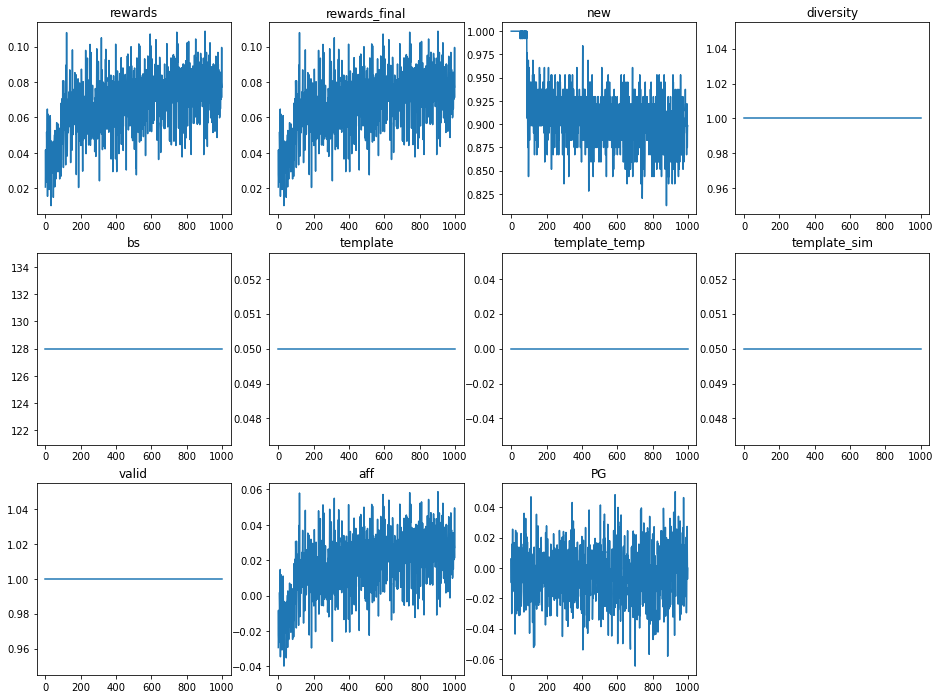

In [ ]:
env.log.plot_metrics()

## Generating Samples

Here we'll grab 100 random smiles from our dataset and generate a series of improved smiles. We plot a scatter between the source score and the maximum generated target score

In [ ]:
sampler1.repeats = 100
inputs = np.random.choice(list(all_smiles), 100, replace=False)
inputs = [remove_stereo(i) for i in inputs]
samples = sampler1.sample_outputs(inputs, 90)
samples = list(set(samples))

hps = template_cb.get_hps(samples)
samples = [samples[i] for i in range(len(samples)) if hps[i]]
samples = [(i[0], remove_stereo(i[1])) for i in samples]
samples = list(set(samples))
sample_df = pd.DataFrame([i[0] for i in samples], columns=['source'])
sample_df['target'] = [i[1] for i in samples]
sample_df['source_reward'] = aff_reward_contrastive.compute_and_clean(sample_df.source.values)
sample_df['target_reward'] = aff_reward_contrastive.compute_and_clean(sample_df.target.values)

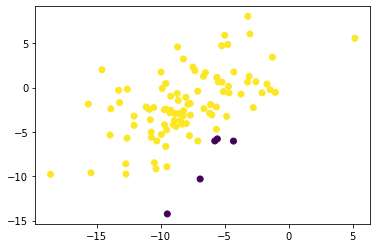

In [ ]:
gb = sample_df.groupby('source')
sr = gb.source_reward.mean()
tr = gb.target_reward.max()
plt.scatter(sr, tr, c=tr>sr)

We can look at iteratively applying the model to a series of compounds to develop a chain of improved versions

In [ ]:
agent.model.eval();

In [ ]:
progressions = []
rewards = []
sampler1.repeats = 100

for i in range(10):
    smile = remove_stereo(list(all_smiles)[8])
    progression = [smile]
    
    reward = [np.atleast_1d(aff_reward_contrastive.compute_and_clean([smile]))[0]]

    for j in range(10):
        current_smile = progression[-1]
        new_samples = sampler1.sample_outputs([current_smile], 90)
        new_samples = list(set(new_samples))
        clean_samples = []
        
        for sample in new_samples:
            source, target = sample
            if to_mol(target) is not None:
                target = remove_stereo(target)
                if not source==target and template_cb.get_hps([(source, target)])[0]:
                    clean_samples.append((source, target))

        if clean_samples:
            output_smiles = [i[1] for i in clean_samples]
            r = np.atleast_1d(aff_reward_contrastive.compute_and_clean(output_smiles))
            if r.max()>reward[-1]:
                progression.append(output_smiles[r.argmax()])
                reward.append(r[r.argmax()])
        else:
            break
            
    progressions.append(progression)
    rewards.append(reward)

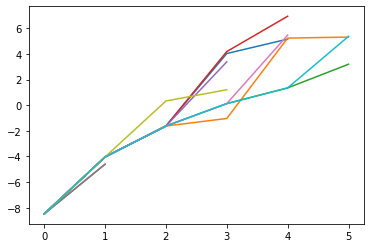

In [ ]:
for r in rewards:
    plt.plot(r)

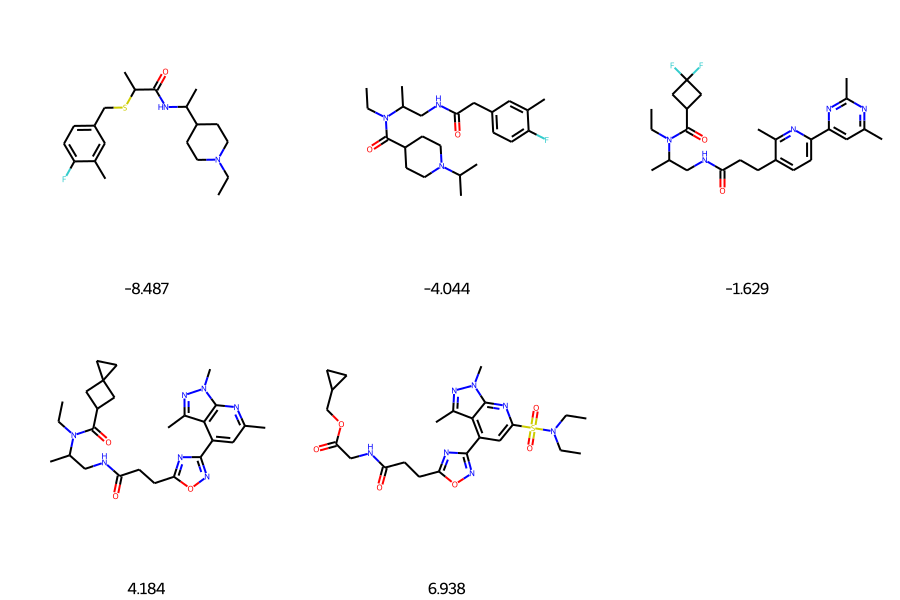

In [ ]:
idx = np.array([i[-1] for i in rewards]).argmax()
draw_mols(to_mols(progressions[idx]), legends=[f"{i:.3f}" for i in rewards[idx]])